# Missing Data Imputation

Missing data imputation implies filling the missing entries in our data, which can be tabular data, images, time series, with "reasonable" values. Ideally, the imputed values should be a good guess of the values that are missing, but that we cannot observe.

Very simple techniques for imputing missing values are:
- `zero imputation`: replace the missing values with a $0$.
- `mean imputation`: replace with the mean value of a given feature in the dataset.
- `last value carried-forward`, also called `forward-filling`, replaces the missing value with the last observed one.

In this notebook we see how to perform imputation of missing data using a Reservoir. Hopefully, we will manage to impute missing values more precisely than the simple baseline approaches.

We start by defining some utility functions.

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Local imports
from reservoir_computing.datasets import ClfLoader
from reservoir_computing.reservoir import Reservoir

np.random.seed(0) # for reproducibility

def plot_missing_data(data):
    """
    Plots the missing data mask.
    Red = missing.
    Green = data available.
    """

    data = data.T
    missing_mask = ~np.isnan(data)

    _, ax = plt.subplots(figsize=(8, 3))
    _ = ax.imshow(missing_mask, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax.set_title("Missing Data Visualization", fontsize=16)
    ax.set_xlabel("Time Steps", fontsize=14)
    ax.set_ylabel("Features", fontsize=14)
    plt.tight_layout()
    plt.show()

def forward_fill_timewise(data_3d):
    """
    Replace the missing values with the last observed value
    along the time dimension.
    The input `data_3d` is a 3-dimensional array of shape [N, T, V].
    If the missing value is at the first time step, replace it with zero.
    """
    N, T, V = data_3d.shape
    for n in range(N):
        for v in range(V):
            for t in range(T):
                if np.isnan(data_3d[n, t, v]):
                    if t == 0:
                        data_3d[n, t, v] = 0.0
                    else:
                        data_3d[n, t, v] = data_3d[n, t - 1, v]
    return data_3d

## All features missing

We will consider two settings. In the first, all the features are missing from the time series at the same time.

In a second setting, that we will see later, only a subset of the features might be missing in the time series at a given time.

### Generate missing values

Next we load the data and add the missing values.

We will use a set of multivariate time series, which we store in an array of size $[N, T, V]$, where $N$ denotes the number of samples, $T$ the length of the time series, and $V$ the number of variables. 

We also normalize the data with a standard scaler, so that the values are centered around $0$ with standard deviation $1$. This is important because if we pass high values to the Reservoir its activations saturate.

We will add missing values using two different patterns.
- `point`: with a probability $p_\text{point}$ (`p_missing_point`), the value $X[n,t,v]$ is missing.
- `block`: with a probability $p_\text{block}$ (`p_missing_block`) and a window of length $w$ (`duration_block`), the values $X[n,t:t+w,v]$ are missing.

In [4]:
# Load the data
Xtr, _, Xte, _ = ClfLoader().get_data('Japanese_Vowels')
X = np.concatenate([Xtr, Xte], axis=0)  
N, T, V = X.shape

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# Parameters for missingness
p_missing_point = 0.2
p_missing_block = 0.1
duration_block = 5

# Add missing values
X_missing = X.copy()
for i in range(N):
    # Random point missing
    point_mask = np.random.rand(T) < p_missing_point
    X_missing[i, point_mask, :] = np.nan

    # Random block missing
    block_mask = np.random.rand(T) < p_missing_block
    for j in range(T):
        if block_mask[j]:
            end_idx = min(j + duration_block, T)
            X_missing[i, j:end_idx, :] = np.nan

print(f"Number of missing values: {np.sum(np.isnan(X_missing))} "
    f"({np.sum(np.isnan(X_missing)) / X_missing.size:.2f}%).")

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)
Number of missing values: 116688 (0.52%).


We can use the utility function we defined before to visualize the pattern of missing data that we generated in a given data sample.

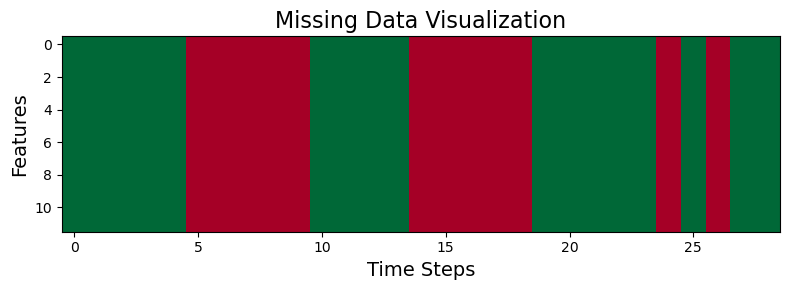

In [5]:
plot_missing_data(X_missing[0])

Next, we will fill the missing values using forward-filling imputation. This is usually a good baseline for time series because, especially if the window of missing values is short, we can assume that the missing values will not be so different from the last observed value.

Note that we do this imputation variable-wise, i.e., we carry forward the last observed value at each variable. 

This imputation is also necessary to get meaningful states out of the Reservoir and to prevent having `nan` in the sequence of Reservoir states.

In [6]:
# Forward-fill the missing entries 
X_missing_filled = forward_fill_timewise(X_missing.copy())
print("Missing values after forward fill:", np.isnan(X_missing_filled).sum()) # should be 0

Missing values after forward fill: 0


### Compute Reservoir states

We are now ready to build our Reservoir and feed it with the time series to get the states.

Importantly, we will use the Reservoir states to perform forecasting, so do **not** want to use a bidirectional readout that also processes the time series backward.
Thus, we must set `bidir=False`.

In [7]:
# Initialize the Reservoir
res = Reservoir(
    n_internal_units=700,
    spectral_radius=0.7,
    leak=0.7,
    connectivity=0.2,
    input_scaling=0.05)

# Compute the Reservoir states
states = res.get_states(X_missing_filled, bidir=False)  # shape: [N, T, H]
_, _, H = states.shape
print("states.shape:", states.shape)
print("Missing values in states:", np.isnan(states).sum()) # should be 0

states.shape: (640, 29, 700)
Missing values in states: 0


To perform imputation, we will train a readout to do a forecasting task, i.e., given the Readout state $h(t)$ the readout should predict $x(t+h)$ where $h$ is the forecast `horizon`.

The reason why we do forecasting, rather than just mapping $h(t)$ into $x(t)$ is that in this way the readout just learns to copy in output the input values and does not know what to do when the input value (at inference time) will be missing.

In [8]:
horizon = 1  # forecast horizon
states = states[:, :T - horizon, :] # drop the last 'horizon' steps
X_missing_future = X_missing[:, horizon:, :] # drop the first 'horizon' steps

_, T_new, _ = X_missing_future.shape
print(f"After shifting:\n states => {states.shape},\n X_missing_future => {X_missing_future.shape}")


After shifting:
 states => (640, 28, 700),
 X_missing_future => (640, 28, 12)


Before training the readout we have to flatten the states and the inputs into 2-dimensional arrays, because we have to map a single $H$-dimensional vector into a $V$-dimensional one. 

To flatten the data, we concatenate the sample and the time dimensions. This is OK, because the Reservoir should have embedded the historical information into its states, which can then be treated independently.

In [9]:
# Flatten the states and the input values
states_2d = states.reshape(N * T_new, H)
X_missing_future_2d = X_missing_future.reshape(N * T_new, V)

### Train the readout

Clearly, we can train the readout only on the instances $\{h(t), x(t+h)\}$ where the target $x(t+h)$ is not missing. So, we have to first filter out all the time steps where the target is missing.

Then, we will define the readout and fit it to the training data that we defined. We will use a simple Ridge Regressor but, of course, more sophisticated regressors can be used.

In [10]:
# Keep only rows with no missing target
not_missing_mask = ~np.isnan(X_missing_future_2d).any(axis=1)
X_train = states_2d[not_missing_mask]
Y_train = X_missing_future_2d[not_missing_mask]
print("Train samples (rows) with no missing output:", X_train.shape[0])

# Create and train the readout
model = Ridge(alpha=1)
model.fit(X_train, Y_train)

Train samples (rows) with no missing output: 8387


Ridge(alpha=1)

### Impute missing values and evaluate performances

Once the readout is trained, we can use it to predict **all** the target values, including those with missing values that we excluded from the training.

In [11]:
predictions_2d = model.predict(states_2d)  # shape: [N*T_new, V]

At this point, we will replace all the missing values in `X_missing_future` with the predicted values, which represent the imputed ones.

In [12]:
# Fill with the missing values
X_imputed_future_2d = X_missing_future_2d.copy()
missing_mask_2d = np.isnan(X_imputed_future_2d)
X_imputed_future_2d[missing_mask_2d] = predictions_2d[missing_mask_2d]

# Reshape back to the original shape
X_imputed_future = X_imputed_future_2d.reshape(N, T_new, V)

Sine our imputation is based on prediction, we do not have imputed values for the first `horizon` steps. So, we will take those steps from `X_missing_filled`, while the rest from `X_imputed_future`.

In [13]:
X_imputed = X_missing_filled.copy()  # start with forward-filled
X_imputed[:, horizon:, :] = X_imputed_future

Done! At this point, we can check the performance of our imputation method by computing the MSE between the time seris with imputed values and the original one where the values are not missing.

We can also compare against the imputation obtained with the other simple baselines.

Note that in this case zero- and mean-imputations give the same result because the data are normalized with a standard scaler.

In [14]:
# Compute zero-imputed values
X_zero_imputed = X_missing.copy()
X_zero_imputed[np.isnan(X_zero_imputed)] = 0.0

# Compute mean-imputation with SimpleImputer
imp = SimpleImputer(strategy='mean')
X_mean_imputed = imp.fit_transform(X_missing.reshape(N * T, V)).reshape(N, T, V)

# Print the MSE between the true and the imputed values
mse_imputed = np.mean((X - X_imputed)**2)
print(f"MSE (Reservoir imp): {mse_imputed:.4f}")
mse_filled = np.mean((X - X_missing_filled)**2)
print(f"MSE (f-fill imp): {mse_filled:.4f}")
mse_zero_imputed = np.mean((X - X_zero_imputed)**2)
print(f"MSE (zero imp): {mse_zero_imputed:.4f}")
mse_mean_imputed = np.mean((X - X_mean_imputed)**2)
print(f"MSE (mean imp): {mse_mean_imputed:.4f}")

MSE (Reservoir imp): 0.2500
MSE (f-fill imp): 0.3843
MSE (zero imp): 0.4452
MSE (mean imp): 0.4454


We can also make a visualization of the true and imputed values.

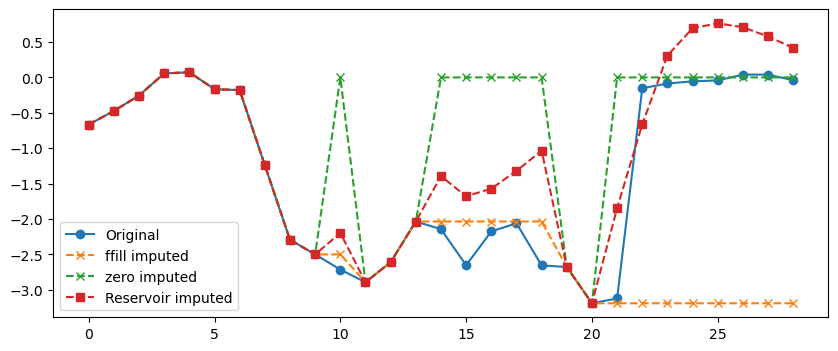

In [15]:
sample_idx, feature_idx = 2,9

plt.figure(figsize=(10, 4))
plt.plot(X[sample_idx, :, feature_idx], 'o-', label='Original')
plt.plot(X_missing_filled[sample_idx, :, feature_idx], 'x--', label='ffill imputed')
plt.plot(X_zero_imputed[sample_idx, :, feature_idx], 'x--', label='zero imputed')
plt.plot(X_imputed[sample_idx, :, feature_idx], 's--', label='Reservoir imputed')
plt.legend()
plt.show()

## Partial missing features

In this setting, we allow only a subset of the features to be missing at each time step. This can happen, for example, when we have $V$ independet sensors and only a few of them are not collecting the measuremements.

### Generate missing values

Here, we modify the procedure for generating missing values.

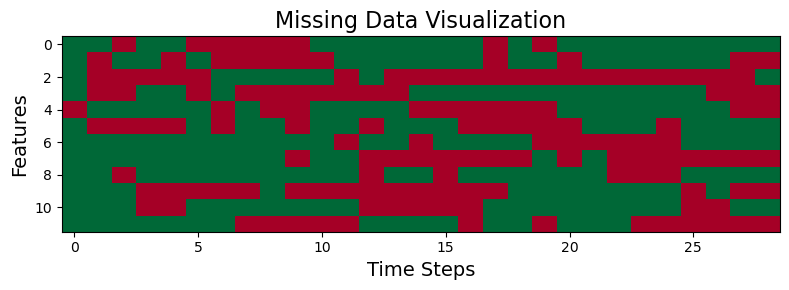

Number of missing values: 112700 (0.51%).


In [16]:
p_missing_point = 0.2
p_missing_block = 0.1
duration_block = 5

X_missing = X.copy()
for i in range(N):
    # Random point missing -- each feature gets its own mask
    pmask = np.random.rand(T, V) < p_missing_point
    X_missing[i, pmask] = np.nan

    # Random block missing -- each feature gets its own blocks
    for v in range(V):
        block_mask = np.random.rand(T) < p_missing_block
        for j in range(T):
            if block_mask[j]:
                end_idx = min(j + duration_block, T)
                X_missing[i, j:end_idx, v] = np.nan

plot_missing_data(X_missing[0])

print(f"Number of missing values: {np.sum(np.isnan(X_missing))} "
    f"({np.sum(np.isnan(X_missing)) / X_missing.size:.2f}%).")

Next, we repeat the same steps as before.

In [17]:
# Forward-fill the missing entries before computing the reservoir states
X_missing_filled = forward_fill_timewise(X_missing.copy())

# Create the Reservoir
res = Reservoir(
    n_internal_units=700,
    spectral_radius=0.7,
    leak=0.7,
    connectivity=0.2,
    input_scaling=0.05)

# Compute the Reservoir states
states = res.get_states(X_missing_filled, bidir=False)
_, _, H = states.shape

# Sift the states and the input values by horizon
horizon = 1
states = states[:, :T - horizon, :]
X_missing_future = X_missing[:, horizon:, :]
_, T_new, _ = X_missing_future.shape

# Flatten the states and the input values
states_2d = states.reshape(N * T_new, H) 
X_missing_future_2d = X_missing_future.reshape(N * T_new, V) 

Before, we were mapping the Reservoir state $h(t) \in \mathbb{R}^H$ into the future input $x(t+h) \in \mathbb{R}^V$, which was either completely missing or completely available.

This time, some variables can be missing and other be present, meaning that we need to predict a variable $i$ and a variable $j$ independently.
In other words, we need to train $V$ independent readouts, each one mapping the state $h(t)$ into the $v$-th variable $x_v(t+h)$.

In [18]:
predictions_2d = np.zeros_like(X_missing_future_2d) 

for v in range(V):
    # For feature v, identify rows where the target is not missing
    not_missing_mask_v = ~np.isnan(X_missing_future_2d[:, v])
    
    # Training data: states + single feature's target
    X_train_v = states_2d[not_missing_mask_v]
    y_train_v = X_missing_future_2d[not_missing_mask_v, v]
    print(f"Feature {v}: #train samples = {len(y_train_v)}")
    
    # Fit a ridge model (or any regressor) for this feature
    model_v = Ridge(alpha=1.0)
    model_v.fit(X_train_v, y_train_v)
    
    # Predict for ALL time steps (including missing) in states_2d
    predictions_2d[:, v] = model_v.predict(states_2d)

Feature 0: #train samples = 8815
Feature 1: #train samples = 8741
Feature 2: #train samples = 8488
Feature 3: #train samples = 8854
Feature 4: #train samples = 8823
Feature 5: #train samples = 8856
Feature 6: #train samples = 8643
Feature 7: #train samples = 8908
Feature 8: #train samples = 8752
Feature 9: #train samples = 8518
Feature 10: #train samples = 8610
Feature 11: #train samples = 8510


The next steps are similar to those taken before: we take the predictions as imputed values and put them in the correct place where the data are missing.

In [19]:
X_imputed_future_2d = X_missing_future_2d.copy()
missing_mask_2d = np.isnan(X_imputed_future_2d)  

# Fill with feature-specific predictions
X_imputed_future_2d[missing_mask_2d] = predictions_2d[missing_mask_2d]

# Reshape back to [N, T_new, V]
X_imputed_future = X_imputed_future_2d.reshape(N, T_new, V)

#  Use the forward-filled data for the first 'horizon' steps
X_imputed = X_missing_filled.copy()  
X_imputed[:, horizon:, :] = X_imputed_future

To conclude, we compare the results obtained with the other imputation methods. Also in this case, we see that we obtain better performance with the Reservoir-based imputation compared to other imputation techniques.

In [21]:
# Compute zero-imputed values
X_zero_imputed = X_missing.copy()
X_zero_imputed[np.isnan(X_zero_imputed)] = 0.0

# Print the MSE between the true and the imputed values
mse_imputed = np.mean((X - X_imputed)**2)
print(f"MSE (Reservoir imp): {mse_imputed:.4f}")
mse_filled = np.mean((X - X_missing_filled)**2)
print(f"MSE (f-fill imp): {mse_filled:.4f}")
mse_zero_imputed = np.mean((X - X_zero_imputed)**2)
print(f"MSE (zero imp): {mse_zero_imputed:.4f}")

MSE (Reservoir imp): 0.3154
MSE (f-fill imp): 0.4565
MSE (zero imp): 0.5047
